- Dataset: https://www.kaggle.com/datasets/pashupatigupta/emotion-detection-from-text/data

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
df = pd.read_csv(r'tweet_emotions.csv')
df2 = df.copy()

In [44]:
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


Removing useless column:

In [45]:
df.drop(columns=['tweet_id'], inplace=True)
df.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  40000 non-null  object
 1   content    40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


No null rows present.

Checking for number of sentiment labels in dataset:

In [6]:
distinct_sentiment_count = df['sentiment'].nunique()
print(f"Number of distinct values in the 'sentiment' column: {distinct_sentiment_count}")

Number of distinct values in the 'sentiment' column: 13


In [7]:
sentiment_counts = df['sentiment'].value_counts()

for sentiment, count in sentiment_counts.items():
    print(f"{sentiment} : {count}")


neutral : 8638
worry : 8459
happiness : 5209
sadness : 5165
love : 3842
surprise : 2187
fun : 1776
relief : 1526
hate : 1323
empty : 827
enthusiasm : 759
boredom : 179
anger : 110


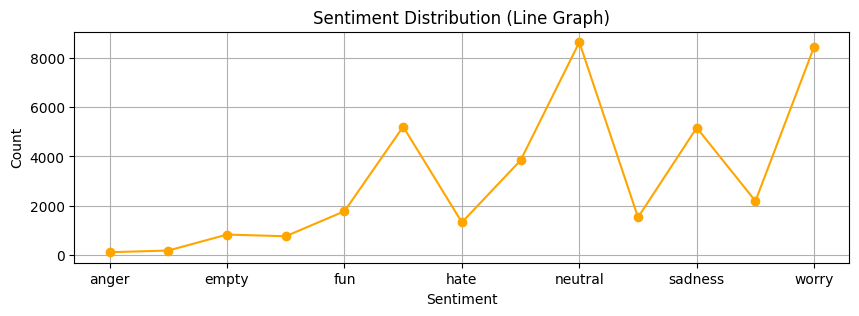

In [8]:
plt.figure(figsize=(10, 3))
sentiment_counts.sort_index().plot(kind='line', marker='o', color='orange')
plt.title('Sentiment Distribution (Line Graph)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.grid(True)
plt.show()

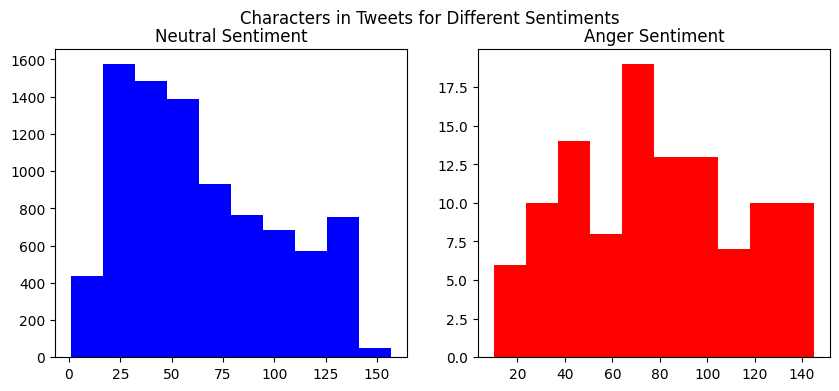

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

df_neutral = df[df['sentiment'] == 'neutral']['content'].str.len()
ax1.hist(df_neutral, color='blue')
ax1.set_title("Neutral Sentiment")

df_anger = df[df['sentiment'] == 'anger']['content'].str.len()
ax2.hist(df_anger, color='red')
ax2.set_title("Anger Sentiment")

fig.suptitle("Characters in Tweets for Different Sentiments")
plt.show()

            Applying ML Classification Model

In [85]:
df2.drop(columns=['tweet_id'], inplace=True)
df2.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [86]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download('stopwords')
nltk.download('punkt')

def clean_text(text):
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

df2['cleaned_content'] = df2['content'].apply(clean_text)
df2[['sentiment', 'cleaned_content']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,sentiment,cleaned_content
0,empty,tiffanylue know listenin bad habit earlier sta...
1,sadness,Layin n bed headache ughhhhwaitin call
2,sadness,Funeral ceremonygloomy friday
3,enthusiasm,wants hang friends SOON
4,neutral,dannycastillo want trade someone Houston ticke...


Performing Manual Sampling since the data is too large for my PC:

In [87]:
import pandas as pd

# Assuming df2 is your original DataFrame with 'cleaned_content' and 'sentiment' columns
# Sample rows per sentiment
df2_sampled = pd.DataFrame()

rows_per_sentiment = 500

for sentiment in df2['sentiment'].unique():
    sentiment_rows = df2[df2['sentiment'] == sentiment].sample(rows_per_sentiment, replace=True)
    df2_sampled = pd.concat([df2_sampled, sentiment_rows])

df2_sampled.reset_index(drop=True, inplace=True)
df2_sampled.drop(columns=['content'], inplace=True)
df2_sampled.head()

,sentiment,cleaned_content
0,empty,KenRamirez Hi Ken checking quickly checking ba...
1,empty,GeezusHaberdash Awww told would change suggest...
2,empty,RF target DNDN near days low
3,empty,meeksdigital havent worked long time kinda mis...
4,empty,lizzieberries also bored school third freeless...


In [88]:
bert_df = df2_sampled.copy()
df2_sampled['sentiment'].value_counts()

sentiment
empty         500
sadness       500
enthusiasm    500
neutral       500
worry         500
surprise      500
love          500
fun           500
hate          500
happiness     500
boredom       500
relief        500
anger         500
Name: count, dtype: int64

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import joblib

df2_sampled = pd.DataFrame()

rows_per_sentiment = 500

for sentiment in df2['sentiment'].unique():
    sentiment_rows = df2[df2['sentiment'] == sentiment].sample(rows_per_sentiment, replace=True)
    df2_sampled = pd.concat([df2_sampled, sentiment_rows])

df2_sampled.reset_index(drop=True, inplace=True)

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', MultinomialNB()),
])

X_train, X_test, y_train, y_test = train_test_split(
    df2_sampled['cleaned_content'],
    df2_sampled['sentiment'],
    test_size=0.2,
    random_state=42
)

# Train the model using the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

joblib.dump(pipeline, r'sentiment_analysis_model.joblib')

Accuracy: 0.41

Classification Report:
               precision    recall  f1-score   support

       anger       0.66      0.98      0.79        99
     boredom       0.53      0.90      0.66       108
       empty       0.83      0.39      0.53       122
  enthusiasm       0.56      0.41      0.48       111
         fun       0.36      0.28      0.32       102
   happiness       0.17      0.25      0.20        88
        hate       0.43      0.40      0.42        90
        love       0.41      0.40      0.41       109
     neutral       0.32      0.10      0.15       102
      relief       0.28      0.40      0.33        88
     sadness       0.21      0.31      0.25        88
    surprise       0.34      0.20      0.25       104
       worry       0.25      0.22      0.24        89

    accuracy                           0.41      1300
   macro avg       0.41      0.40      0.39      1300
weighted avg       0.43      0.41      0.39      1300



['C:\\Users\\hp\\Desktop\\sem6\\PL\\lab4\\home-task\\sentiment_analysis_model.joblib']

In [ ]:
from flask import Flask, render_template, request
import joblib

app = Flask(__name__)

# Load the trained model
model = joblib.load(r'sentiment_analysis_model.joblib')

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    if request.method == 'POST':
        text = request.form['text']
        prediction = model.predict([text])[0]
        return render_template('index.html', prediction=prediction, text=text)

if __name__ == '__main__':
    app.run(debug=True)

            Applying BERT

In [91]:
bert_df.head()

,sentiment,cleaned_content
0,empty,KenRamirez Hi Ken checking quickly checking ba...
1,empty,GeezusHaberdash Awww told would change suggest...
2,empty,RF target DNDN near days low
3,empty,meeksdigital havent worked long time kinda mis...
4,empty,lizzieberries also bored school third freeless...


Loading Pre-trained BERT model, performing tokenization according to expected input for bert.

In [93]:
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader
from torch.nn.functional import softmax
import torch

# Load your DataFrame
# bert_df = ...

# Load the smaller pre-trained BERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

# Tokenize the cleaned_content column
tokenized_texts = bert_df['cleaned_content'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

# Pad sequences to the same length
max_len = max(map(len, tokenized_texts))
padded_sequences = torch.tensor([i + [0]*(max_len-len(i)) for i in tokenized_texts])

# Create attention masks
attention_masks = torch.where(padded_sequences != 0, torch.tensor(1), torch.tensor(0))

# Convert to PyTorch tensors
input_ids = padded_sequences
attention_masks = attention_masks

# Create DataLoader
data = torch.utils.data.TensorDataset(input_ids, attention_masks)
dataloader = DataLoader(data, batch_size=4, shuffle=False)

# Set the model to evaluation mode
model.eval()

# Make predictions
predictions = []

with torch.no_grad():
    for batch in dataloader:
        inputs, masks = batch
        outputs = model(inputs, attention_mask=masks)
        logits = outputs.logits
        probabilities = softmax(logits, dim=1)
        predictions.extend(torch.argmax(probabilities, dim=1).tolist())

# Map predicted labels back to the original sentiment labels
predicted_sentiments = ["positive" if pred == 1 else "negative" for pred in predictions]

# Add the predicted sentiment to the DataFrame
bert_df['predicted_sentiment'] = predicted_sentiments

# Display the DataFrame with predicted sentiments
print(bert_df[['sentiment', 'predicted_sentiment', 'cleaned_content']])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


     sentiment predicted_sentiment  \
0        empty            positive   
1        empty            positive   
2        empty            positive   
3        empty            positive   
4        empty            positive   
...        ...                 ...   
6495     anger            positive   
6496     anger            positive   
6497     anger            positive   
6498     anger            positive   
6499     anger            positive   

                                        cleaned_content  
0     KenRamirez Hi Ken checking quickly checking ba...  
1     GeezusHaberdash Awww told would change suggest...  
2                          RF target DNDN near days low  
3     meeksdigital havent worked long time kinda mis...  
4     lizzieberries also bored school third freeless...  
...                                                 ...  
6495  _hayles u serious touched arse ohmygod u bitch...  
6496  mikeavila ack read show thats horrible account...  
6497          anz_roc

In [ ]:
joblib.dump((model, tokenizer), r'bert_sentiment_model.joblib')